# ***EM algorithm for Gaussian Mixture Model***

## Author : Cyril Equilbec

The goal of this lab is to derive and apply the Expectation-Maximization algorithm to Gaussian Mixture Model.

# Question 1

Let $x_k$ be a vector with $m$ components and $\gamma$ defined as : $$\gamma_i(x_k) = \frac{\pi_i \mathcal{N}(x_k,\mu_i, \Sigma_i)}{\sum\limits_{j=1}^K \pi_j \mathcal{N}(x_k,\mu_j, \Sigma_j)}$$

We define $l_i$ as $$l_i = \log\pi_i \mathcal{N}(x_k,\mu_i, \Sigma_i)$$

Then $$\log  \gamma_i(x) = l_i - \log \sum\limits_{j=1}^K e^{l_j}$$

From the previous lab, we know how to compute $\log \sum\limits_{j=1}^K e^{l_j}$ in a numerical stable manner. 

Let's compute $l_i$ efficiently.

$$l_i = \log \frac{\pi_i}{(2\pi)^{m/2}\sqrt{det(\Sigma_i)}}e^{-0.5*(x_k-\mu_i)^T\Sigma_i^{-1}(x_k-\mu_i)}$$

$$ = \log \frac{\pi_i}{(2\pi)^{m/2}\sqrt{det(\Sigma_i)}} - \frac{1}{2}(x_k-\mu_i)^T\Sigma_i^{-1}(x_k-\mu_i) $$


$$
\boxed {l_i = \log \pi_i - \frac{m}{2} \log 2\pi - \frac{1}{2} \log det(\Sigma_i) - \frac{1}{2}(x_k-\mu_i)^T\Sigma_i^{-1}(x_k-\mu_i)}
$$

$det(\Sigma_i)$ might be very small and leads to numerical instabilities.

Since $\Sigma_i$ is a covariance matrix, it is symetric and positive semi-definite ($det(\Sigma_i) \ge 0$) and it admits a Cholesky decomposition such that : $$\Sigma_i = LL^T$$ where $L$ is a lower triangular matrix

Then, $det(\Sigma_i) = det(L) * det(L^T) = det(L)^2$ so $\log det(\Sigma_i) = 2\log det(L)$ 

Since L is a lower triangular matrix, its determinant is very easy to compute : it's the product of its diagonal elements.

**Numpy already provides a method to compute this log-det in a numericaly stable manner : numpy.linalg.slogdet**

# Question 2

Let recall that at time step $t$, we have : $$\gamma_i^t(x) = \frac{\pi_i^t \mathcal{N(x,\mu_i^t, \Sigma_i^t)}}{\sum\limits_{j=1}^K \pi_j^t \mathcal{N(x,\mu_j^t, \Sigma_j^t)}}$$

And our Expectation is : $$L_t(\theta_k) = \sum\limits_{n=1}^N \sum\limits_{k=1}^K \gamma_k^t(x_n) \mathcal{N}(x_n,\mu_k, \Sigma_k) + \sum\limits_{n=1}^N \sum\limits_{k=1}^K \gamma_k^t(x_n) \log \pi_k$$

Where $\theta_k = (\pi_k, \mu_k, \Sigma_k)$

We see that the first part only depends on $\mu_k, \Sigma_k$ while the second part only depends on $\pi_k$. We can therefore maximize those terms separatly.



## 1) $\pi_k^{t+1}$

Let's maximize $L_t(\theta)$ with respect to $\pi_k$ under the constraint that $\sum\limits_{k=1}^K \pi_k = 1$

By definition, 
$\pi_k^{t+1} = \underset{\pi_k}{\mathrm{argmax}} \hspace{0.2cm} L_t(\theta)$ with $\sum\limits_{k=1}^K \pi_k = 1$

To solve this problem, we form the Lagrangian $$\Lambda = \sum\limits_{n=1}^N \sum\limits_{k=1}^K \gamma_k^t(x_n) \log \pi_k + \lambda (\sum\limits_{k=1}^K \pi_k - 1)$$

Taking the derivative of the Lagrangian with respect to $\pi_k$ leads to:

$$\frac{\partial \Lambda}{\partial \pi_k} = \sum\limits_{n=1}^N \frac{\partial}{\partial \pi_k} \sum\limits_{k=1}^K \gamma_k^t(x_n) \log \pi_k + \lambda \frac{\partial}{\partial \pi_k} (\sum\limits_{k=1}^K \pi_k - 1)$$

Those partial derivatives are non-null only when reaching index $k$ inside the sum, hence this result : 

$$\frac{\partial \Lambda}{\partial \pi_k} = \sum\limits_{n=1}^N \frac{1}{\pi_k} \gamma_k^t(x_n) + \lambda$$

Setting this to 0 gives $\pi_k^* = \pi_k^{t+1}$, 

$$\sum\limits_{n=1}^N \gamma_k^t(x_n) = - \lambda \pi_k^* \hspace{0.2cm}and\hspace{0.2cm} \pi_k^* = -\frac{1}{\lambda} \sum\limits_{n=1}^N \gamma_k^t(x_n) $$

To find the value of $\lambda$ one can sum for $k=1$ to $k = K$ : 

$$\sum\limits_{n=1}^N \sum\limits_{k=1}^K \gamma_k^t(x_n) = - \lambda \sum\limits_{k=1}^K\pi_k^*$$

We recall that $\gamma_k^t(x_n)$ and $\pi_k^*$ are probabilities therefore their sum equal 1. Hence $\lambda = - N$

And our final result : 

\begin{equation}
\boxed{
\pi_k^{t+1} = \frac{1}{N} \sum\limits_{n=1}^N \gamma_k^t(x_n)
}
\end{equation}

## 2) $\mu_k^{t+1}$

Let's maximize $L_t(\theta)$ with respect to $\mu_k$
\\

By definition,
$\mu_k^{t+1} = \underset{\mu_k}{\mathrm{argmax}} \hspace{0.2cm} L_t(\theta)$ 
\\

First, let's re-use a previous result and introduce another intermediate result:

$$\log \mathcal{N}(x,\mu_i, \Sigma_i) =  - \frac{N}{2} \log 2\pi - \frac{1}{2} \log det(\Sigma_i) - \frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)$$

Expending this expression gives : 

\begin{equation}
\begin{split}
\log \mathcal{N}(x,\mu_i, \Sigma_i) = - \frac{N}{2} \log 2\pi - \frac{1}{2} \log det(\Sigma_i) - \frac{1}{2}(x_i^T \Sigma_i^{-1}x_i - x_i^T\Sigma_i^{-1}\mu_i - \mu_i^T\Sigma_i^{-1}x_i + \mu_i^T\Sigma_i^{-1}\mu_i)
\end{split}
\end{equation}

Taking the derivative of this expression with respect to $\mu_i$ leads to: 

$$ \frac{\partial}{\partial \mu_i}\log \mathcal{N(x,\mu_i, \Sigma_i)} = - \frac{1}{2} (- x_i^T\Sigma_i^{-1} -\Sigma_i^{-1} x_i + (\Sigma_i^{-1}+(\Sigma_i^{-1})^T)\mu_i )$$


Since $- x_i^T\Sigma_i^{-1} = - \Sigma_i^{-1}x_i$ and $\Sigma_i$ is a symmetric positive definite matrix (covariance matrix) then $\Sigma_i^{-1}$ is also symmetric and we have $\Sigma_i^{-1}+(\Sigma_i^{-1})^T = 2\Sigma_i^{-1}$, we can rewrite our derivative as : 

$$ \frac{\partial}{\partial \mu_i}\log \mathcal{N}(x,\mu_i, \Sigma_i) = - \frac{1}{2} (- 2 \Sigma_i^{-1} x_i + 2\Sigma_i^{-1}\mu_i ) = \Sigma_i^{-1} (x_i - \mu_i )$$



Now, taking the derivative of $L_t(\theta)$ with respect to $\mu_k$ leads to:

$$\frac{\partial L_t(\theta) }{\partial \mu_k} = \frac{\partial}{\partial \mu_k}\sum\limits_{n=1}^N \sum\limits_{k=1}^K \gamma_k^t(x_n) \log \mathcal{N(x_n,\mu_k, \Sigma_k)} $$

$$ = \sum\limits_{n=1}^N  \gamma_k^t(x_n) \Sigma_k^{-1} (x_n - \mu_k )$$

Setting this to 0 gives $\mu_k^* = \mu_k^{t+1}$ : 

$$\sum\limits_{n=1}^N  \gamma_k^t(x_n) \Sigma_k^{-1} (x_n - \mu_k^*) = 0$$



And our final result : 

\begin{equation}
\boxed{
\mu_k^{t+1} = \frac{\sum\limits_{n=1}^N \gamma_k^t(x_n) x_n}{\sum\limits_{n=1}^N \gamma_k^t(x_n)}  
}
\end{equation}

## 3) $\Sigma_k^{t+1}$


Let's maximize $L_t(\theta)$ with respect to $\Sigma_k$


By definition, $\Sigma_k^{t+1} = \underset{\Sigma_k}{\mathrm{argmax}} \hspace{0.2cm} L_t(\theta)$ 

For this update, few intermediate results are required. 


  - $\frac{\partial det(A)}{\partial A} = det(A) A^{-1}$ and $det(A^{-1}) = \frac{1}{det(A)}$
([Source](https://en.wikipedia.org/wiki/Determinant#Derivative))
  - $\frac{\partial\log(f)}{\partial \Sigma_i} = \frac{1}{f}\frac{\partial f}{\partial\Sigma_i}$ (because $\partial \log(f) = \frac{\partial f}{f}$ or by applying the chain-rule)
([Source](https://stats.stackexchange.com/questions/243128/derivation-of-m-step-in-em-algorithm-for-mixture-of-gaussians))

Since $\Sigma_k^{-1}$ appears in the expression of $L_t(\theta)$, we'll differentiate with respect to $\Sigma_k^{-1}$ instead of $\Sigma_k$.

We therefore have : $$ \frac{\partial}{\partial \Sigma_i^{-1}}\log \mathcal{N}(x,\mu_i, \Sigma_i) = \frac{\partial}{\partial \Sigma_i^{-1}} (- \frac{N}{2} \log 2\pi - \frac{1}{2} \log det(\Sigma_i) - \frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i))$$

$$ = \frac{1}{2}\frac{\partial}{\partial \Sigma_i^{-1}} ( \log det(\Sigma_i^{-1}) - (x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i))$$


$$  = \frac{1}{2} ( \frac{1}{det(\Sigma_i^{-1})}\frac{\partial det(\Sigma_i^{-1})}{\partial\Sigma_i^{-1}} - \frac{\partial}{\partial \Sigma_i^{-1}}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i))$$

$$  = \frac{1}{2} ( \Sigma_i - (x-\mu_i)(x-\mu_i)^T)$$

Plugging this result into $\frac{\partial L_t(\theta) }{\partial \Sigma_k}$ gives us :

$$\frac{\partial L_t(\theta) }{\partial \Sigma_k} = \frac{1}{2} \sum\limits_{n=1}^N  \gamma_k^t(x_n) ( \Sigma_k - (x_n-\mu_k)(x_n-\mu_k)^T)$$

Setting this derivative to $0$ gives $\Sigma_k^* = \Sigma_k^{t+1}$

$$\frac{1}{2} \sum\limits_{n=1}^N  \gamma_k^t(x_n) ( \Sigma_k^* - (x_n-\mu_k)(x_n-\mu_k)^T) = 0$$

And our final result : 

\begin{equation}
\boxed{
\Sigma_k^{t+1} = \frac{\sum\limits_{n=1}^N \gamma_k^t(x_n) (x_n-\mu_k)(x_n-\mu_k)^T}{\sum\limits_{n=1}^N \gamma_k^t(x_n)}  
}
\end{equation}

# Conclusion

## The EM algorithm


For the maximization step we only need $\gamma$, therefore the expectation step can be reduced to the simple computation of $\gamma$

Hence the **EM Algorithm for Gaussian Mixture Models**: 

![EM for Gaussian Mixture Models](img/EM_algo.png)

**NB:** The mean vector $\mu$ is a coordinate in N-dimensional space, which represents the location where samples are most likely to be generated. We therefore expect the algorithm to give a good prediction if the random initialization of $\mu$ is close to the real $\mu$.

# Question 3 : Data Generation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
from numpy.random import multivariate_normal, random
from numpy.linalg import norm
from scipy.stats import multivariate_normal as multivariate_image





Each data point is drawn from a GMM distribution such that : $$p(x_k) = \sum_{i = 1}^{K}\pi_i\mathcal{N}(x_k; \mu_i, \Sigma_i)$$

One can generate those points with the introduction of a new random variable $z_k$ such that : 

$$
\left\{
    \begin{array}{ll}
        p(z_k = i) = \pi_i \\
        p(x_k \mid z_k = i) = \mathcal{N}(x_k; \mu_i, \Sigma_i)
    \end{array}
\right.
$$


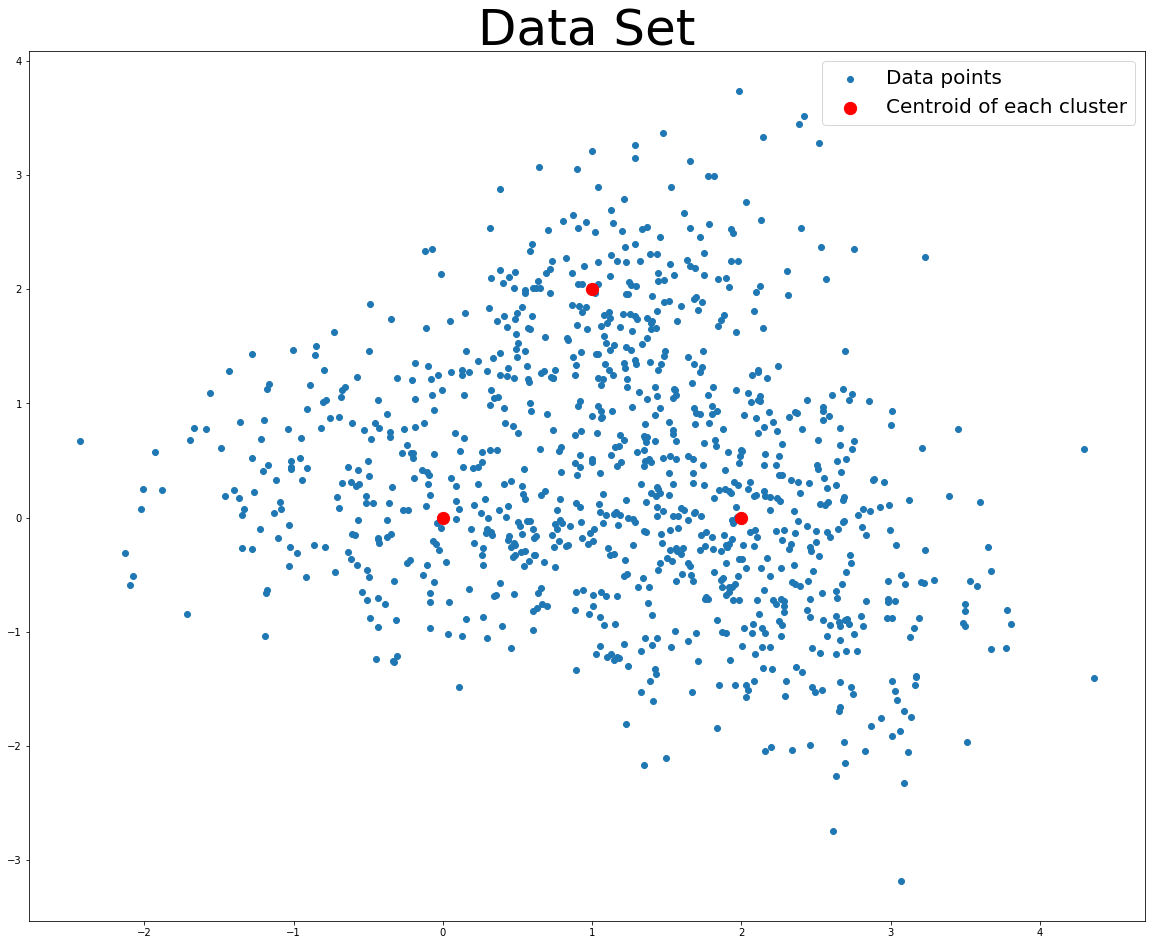

In [2]:
# Number of Gaussian
K = 3
# Contains the true weights
vec_pi = np.array([0.3, 0.2, 0.5])

# Contains the true mean vectors
vec_u  = [np.array([0,0], dtype= float), 
          np.array([1,2], dtype=float), 
          np.array([2,0], dtype=float)]

# Contains the true matrices of covariance
vec_cov = [np.array([[1., -0.25],[-0.25, 0.50]],dtype=float), 
           np.array([[0.50, 0.25],[0.25, 0.50]],dtype=float),
           np.array([[0.50, -0.25],[-0.25, 1]],dtype=float)]


def gen_x(vec_pi = vec_pi, vec_u = vec_u, vec_cov = vec_cov, N = 1000, m = 2):
    X = np.zeros((N, m))
    for i in range(N):
        indx = np.random.choice(K, None, p = vec_pi)
        x = multivariate_normal(vec_u[indx], vec_cov[indx])
        X[i] = x
    return X


# Generate 1000 points from the mean, covariance and weights defined above
X = gen_x()

# Number of points
N = len(X)
# Dimensionality of points
m = len(X[0])

plt.figure(figsize=(20,16))
plt.scatter(X[:, 0], X[:, 1], label = "Data points")
plt.scatter([m[0] for m in vec_u], [m[1] for m in vec_u], c='r', s=150, label="Centroid of each cluster")
plt.title("Data Set").set_fontsize(50)
plt.legend(prop={'size': 20})
plt.show()

# Stable Computation of $l_i$ and $\gamma$

In [3]:
# Stable computation of gamma_i

# From the previous lab
def stable_logsumexp(v):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

def li(x, vec_pi, vec_u, vec_cov, i):
    p = vec_pi[i]
    u = vec_u[i]
    cov = vec_cov[i]
    inv_cov = np.linalg.inv(cov)
    #inv_cov = np.linalg.pinv(cov)
    _, logdet = np.linalg.slogdet(vec_cov[i])
    return np.log(p) - (m * np.log(2 * np.pi) / 2) - (logdet / 2) - ((x - u).T.dot(inv_cov).dot(x - u) / 2) 
    

def stable_log_gamma(x, vec_pi, vec_u, vec_cov, i):
    # Fill a vector containing every lj
    v = [li(x, vec_pi, vec_u, vec_cov, i) for i in range(K)]
    # We compute in a stable manner log sum e^lj
    di = stable_logsumexp(v)
    # gamma_i = li / sum e^lj
    return v[i] - di


# Random initialization

The initilization of the EM algorithm must be random parameters. We recall that for any matrix $X$, $XX^T$ is the covariance matrix of X (while $X^TX$ is the Gram matrix..)

In [4]:
# Vectors used for EM random initialization
def random_gen_param(lmin = 0, lmax = 2):
    # Vector of K weights 
    vec_pi = np.random.random(K)
    vec_pi /= norm(vec_pi, 1) 
    
    # K vectors of size m
    # lmin and lmax are the min/max locations of the points 
    vec_u = [lmax * random(m) + lmin for k in range(K)]
    
    # K covariance matrices of size m x m
    vec_cov = [random((m, m)).dot(random((m, m)).T) for k in range(K)]
    return vec_pi, vec_u, vec_cov


vec_pi_init, vec_u_init, vec_cov_init = random_gen_param()

print("Weights : ", vec_pi_init,"\n\nMean : ",vec_u_init,"\n\nCovariance matrices : ",vec_cov_init)

Weights :  [0.62167644 0.10614455 0.27217901] 

Mean :  [array([1.86978963, 0.63340328]), array([1.01158918, 1.44945303]), array([1.8462534, 0.0973433])] 

Covariance matrices :  [array([[0.79621415, 0.59479464],
       [0.26506376, 0.14670893]]), array([[0.81359927, 0.46719547],
       [0.3750215 , 0.1902806 ]]), array([[0.20033536, 0.0734693 ],
       [0.41917974, 0.58727742]])]


In [5]:
vec_pi_init =  [0.25933635 ,0.20496881, 0.53569485] 

vec_u_init =  [np.array([1.13189582, 1.12381838]), np.array([0.24078752, 1.94788063]), np.array([0.84784993, 0.66775547])] 

vec_cov_init =  [np.array([[0.23134256, 0.45201541],
       [0.2469807 , 0.86915165]]), np.array([[0.22536581, 0.25107062],
       [0.20484022, 0.30117438]]), np.array([[0.85424841, 0.9548391 ],
       [0.82650544, 0.97756103]])]

# EM Algorithm for GMM

## 3.2

**NB:** Another method is used to compute a bit faster the $\gamma_k(x_n)$

In [6]:
def plot_contours(X, vec_u, vec_cov, title):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X[:, 0], X[:, 1])
    gx = np.linspace(*ax.get_xlim(), 100)
    gy = np.linspace(*ax.get_ylim(), 100)
    gx, gy = np.meshgrid(gx, gy)
    colors = ['red', 'green', 'blue']
    g_inputs = np.empty(gx.shape + (2,))
    g_inputs[:, :, 0] = gx
    g_inputs[:, :, 1] = gy
    for k in range(K):
        gaussian_k = multivariate_image.pdf(g_inputs, vec_u[k], vec_cov[k])
        ax.contour(gx, gy, gaussian_k, 0.2 * np.max(gaussian_k), colors=colors[k])
    plt.title(title).set_fontsize(30)

In [7]:
# Faster way to to compute all the gammas in the log domain
def matrix_gamma(X, vec_pi, vec_u, vec_cov):
    gamma = np.zeros((N, K))
    log_exp_li = np.zeros((N, 1))
    for n in range(N):
        # for each point xn, we fill a vector containing the li(xn) = log p_i N(x_n, mu_i, sigma_i)
        v = [li(X[n], vec_pi, vec_u, vec_cov, i) for i in range(K)]
        # we compute log sum exp li(xn)
        log_exp_li[n] = stable_logsumexp(v)
        # log gamma_i = li - log sum exp (li)
        gamma[n]= v - log_exp_li[n]
        # log likelihood = sum over N of log sum exp (li(xn))
    return gamma, np.sum(log_exp_li, 0)

#matrix_gamma(X, vec_pi_init, vec_u_init, vec_cov_init)


def EM(X, pi, u, cov, n_it = 100, plot = True, n_plot = 10):
    vec_pi = pi.copy()
    vec_u = u.copy()
    vec_cov = cov.copy()
    log_likelihood_vec = []
    n_it = n_it
    for t in range(n_it):
        log_gamma, log_likelihood = matrix_gamma(X, vec_pi, vec_u, vec_cov)
        gamma = np.exp(log_gamma)
        if t !=0:
            log_likelihood_vec.append(log_likelihood)
        for k in range(K):
            sum_gamma_k = np.exp(stable_logsumexp(log_gamma[:, k]))
            #sum_gamma_k = np.sum(gamma[:, k]), works as well as far as I tested but it can maybe lead to bug
            vec_pi[k] = sum_gamma_k / N
            vec_u[k]  = np.sum(list(map(lambda x:[x],gamma[:, k])) * X, 0) / sum_gamma_k
            vec_cov[k] = np.sum([gamma[n, k] * np.outer((X[n] - vec_u[k]), (X[n] - vec_u[k])) for n in range(N)], 0) / sum_gamma_k
    
        if plot and t % n_plot == 0:
            if t == 0:
                title = "Initialization"
            else:
                title = "Iteration "+str(t)  
            plot_contours(X, vec_u, vec_cov, title)
    
    return vec_pi, vec_u, vec_cov, log_gamma, log_likelihood_vec, n_it-1

# Visualization of the intermediate and final results 

## 3.2.a

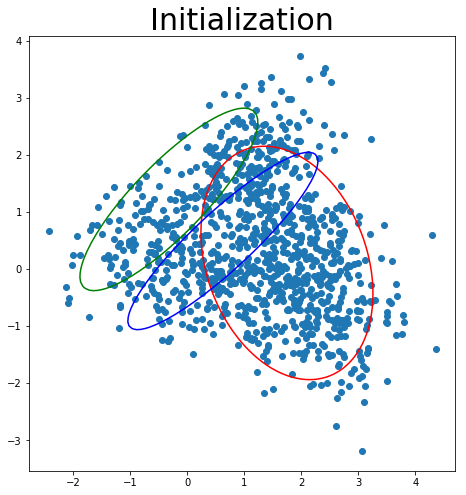

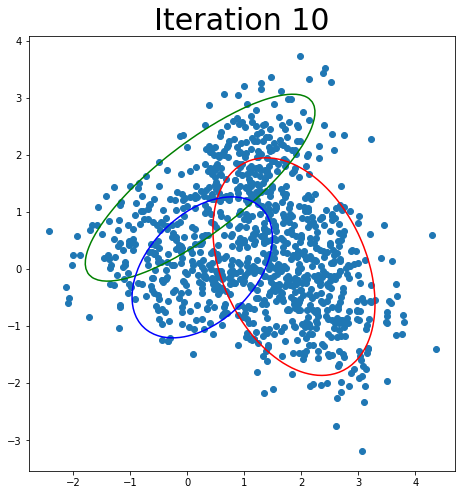

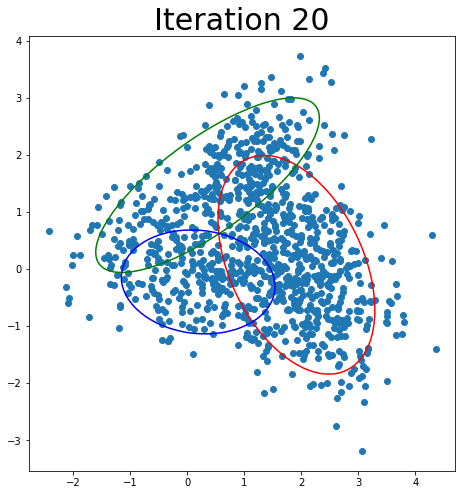

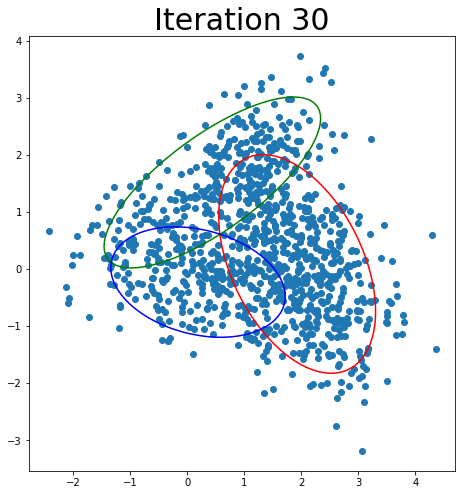

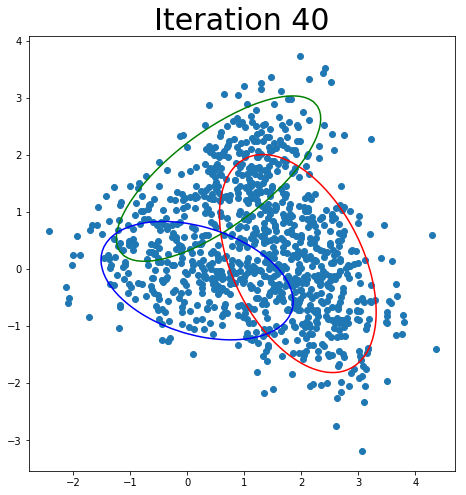

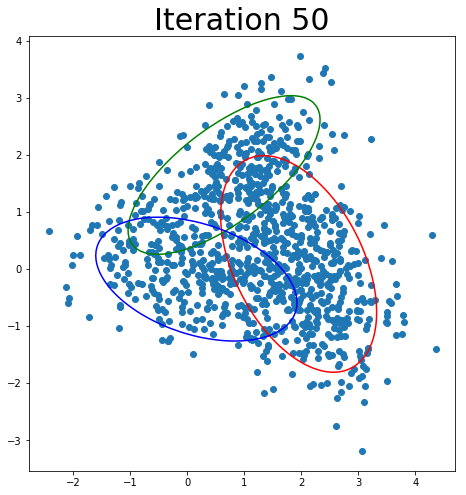

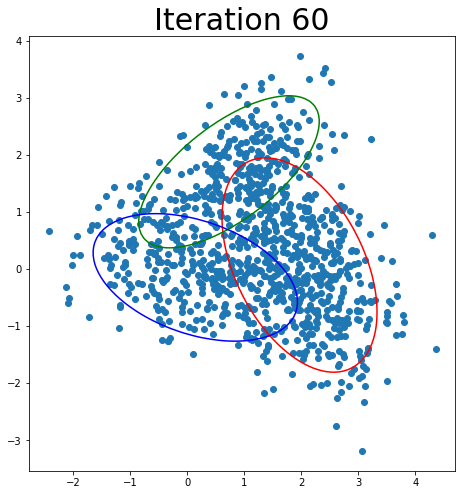

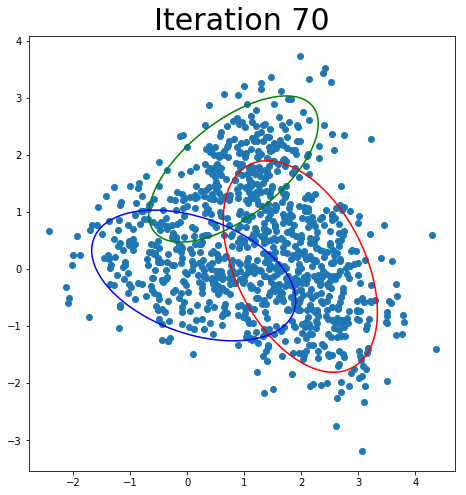

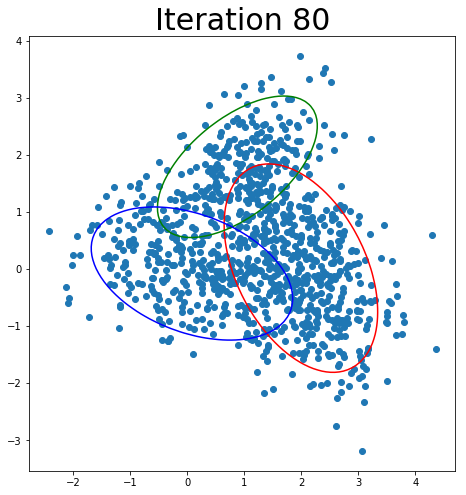

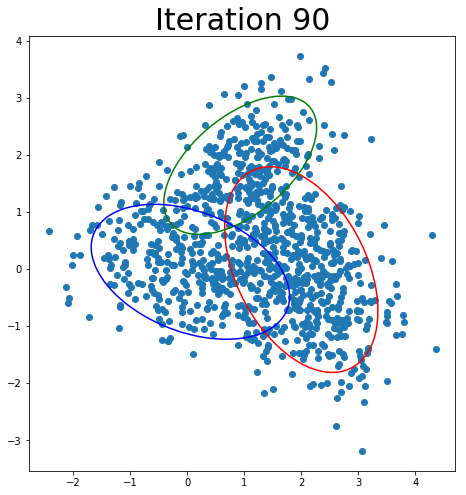

In [8]:
# 100 iterations, plot every 10 iterations
pi, u, cov, Lgamma, L, n_it = EM(X, vec_pi_init, vec_u_init, vec_cov_init, 100, 10)

For each point, we have 3 probabilities $\gamma_1(x_n),\gamma_2(x_n),\gamma_3(x_n)$ which are membership probabilities, this value shows the probability that a given point is explained by the $ith$ Gaussian. We can therefore identify each cluster based on the biggest value of $\gamma_i$ 

i.e : if the biggest value is $\gamma_1(x_n)$ it means that $x_n$ is in the 1st cluster... Since $\log$ is a monotonic function we can apply this to $\log \gamma_i$ as well.

$$
cluster(x_n) = \underset{i}{\arg\max}\gamma_i(x_n) 
$$


Here is a 3-D visualization with level line, inspired by this [example](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/) and a 2-D visualization of the clusters.

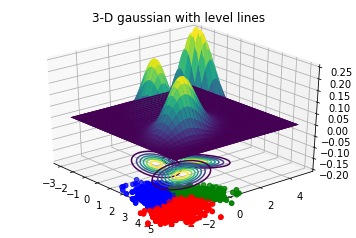

In [27]:
gx = np.linspace(-3, 5, 100)
gy = np.linspace(-3, 5, 100)
gx, gy = np.meshgrid(gx, gy)

pos = np.empty(gx.shape + (2,))
pos[:, :, 0] = gx
pos[:, :, 1] = gy

cluster_colors = ['red', 'green', 'blue']
point_colors = [cluster_colors[np.argmax(Lgamma[n, :])] for n in range(N)]

fig = plt.figure()
for k in range(K):
    gz = multivariate_image.pdf(pos, u[k], cov[k])
    ax = fig.gca(projection='3d')
    ax.plot_surface(gx, gy, gz, rstride=3, cstride=3, antialiased=True, cmap=cm.viridis)
    ax.contour(gx, gy, gz, zdir='z', offset=-0.20)
    ax.scatter(X[:,0],X[:,1],zdir='z', zs=-0.35, color=point_colors)

ax.set_zlim(-0.20,0.25)
# ax.set_zticks(np.linspace(-0.15,0.2, 5))
ax.view_init(30, -40)
plt.title("3-D gaussian with level lines")
plt.show()



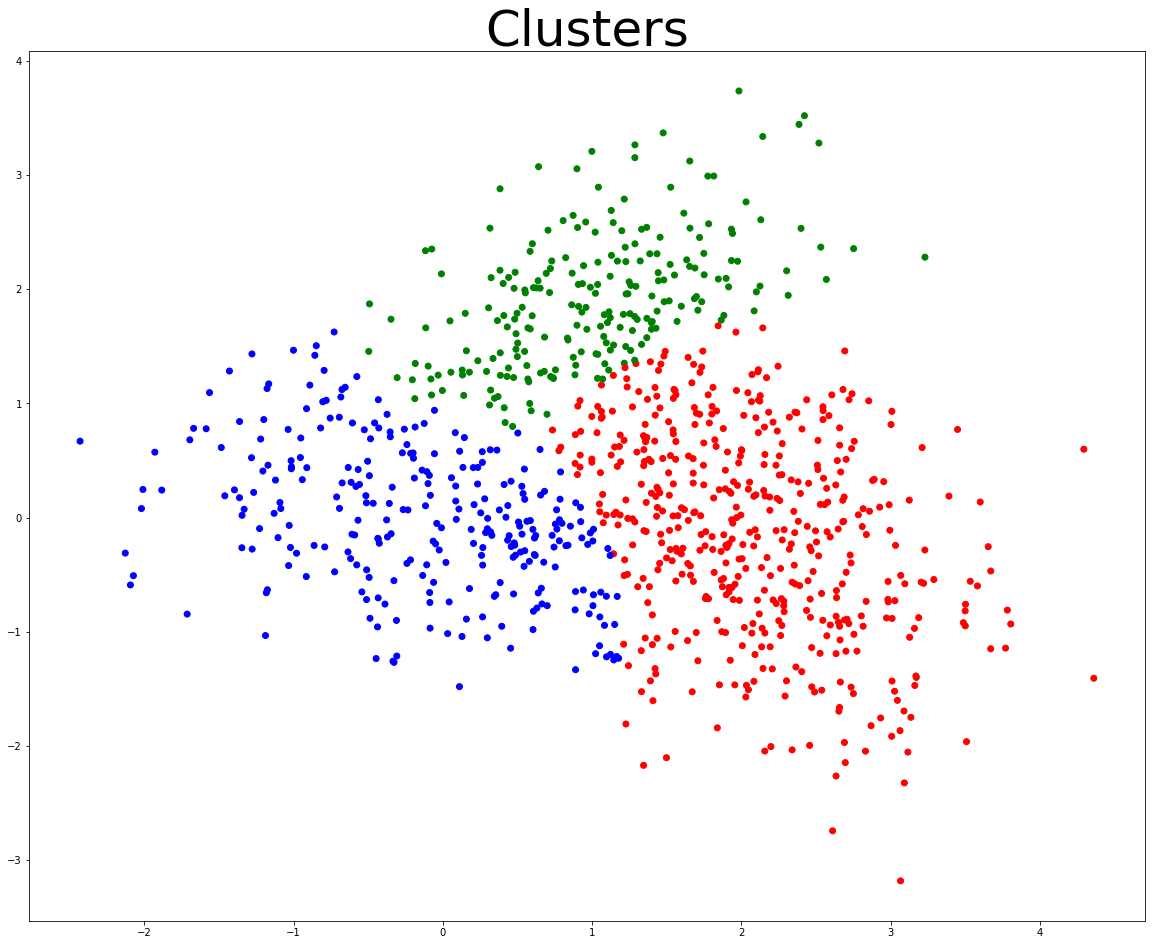

In [10]:
plt.figure(figsize=(20, 16))
plt.scatter(X[:, 0], X[:, 1], color=point_colors)
plt.title("Clusters").set_fontsize(50)
plt.show()

# Log-likelihood

## 3.2.b

The log-likelihood is given by :

$$L = \log p(x_{1:N} \mid \pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})$$

Where the points $x_n$ are i.i.d, this gives :

$$L = \log \prod_{n=1}^N p(x_{n} \mid \pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})$$

$$ L = \sum_{n=1}^N\log\ p(x_{n} \mid \pi_{1:K}, \mu_{1:K}, \Sigma_{1:K})$$

We recall that $$p(x_k) = \sum_{i = 1}^{K}\pi_i\mathcal{N}(x_k; \mu_i, \Sigma_i)$$

Therefore, $$ L = \sum_{n=1}^N\log\ \sum_{i = 1}^{K}\pi_i\mathcal{N}(x_n; \mu_i, \Sigma_i)$$

Finally, 

$$
\boxed {L = \sum_{n=1}^N\log\ \sum_{i = 1}^{K}e^{l_i}}
$$

We recall that for a given point $x$ : $$\log  \gamma_i(x) = l_i - \log \sum\limits_{j=1}^K e^{l_j}$$

This is why we can compute directly this log-likelihood in the same function used to compute the matrice of $\gamma_k(x_n), \forall k,n$ since we already compute for each point the value of $\log \sum\limits_{j=1}^K e^{l_j}$


In [48]:
_, _, _, _, L_opti, _ = EM(X, vec_pi, vec_u, vec_cov, 100, False, 10)

In [49]:
print("Optimal log-likelihood : ", L_opti[-1])

Optimal log-likelihood :  [-2980.54288447]


Text(0.5,1,'Log-likelihood vs iterations')

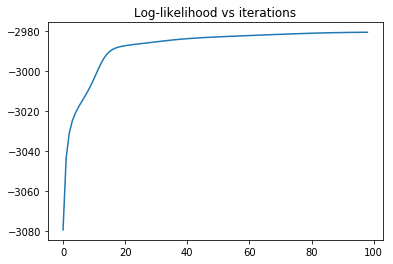

In [11]:
plt.plot(range(n_it), L)
plt.title("Log-likelihood vs iterations")

For this run with this given random initialization, we're almost reaching the optimal log-likelihood which means that our algorithm has successfuly converged toward the global optima.

# Sensitivity of Initialization

## 3.2.c

**NB:** Running the different experiments take 1 - 2 min on my laptop, you might want to lower the number of iterations. 

In [12]:
para_init = []
para_EM   = []

# fills these with true parameters of the model
para_init.append([vec_pi, vec_u, vec_cov])
para_EM.append(EM(X, para_init[-1][0], para_init[-1][1], para_init[-1][2], 100, False))

for exp in range(10):
    
    para_init.append(random_gen_param())
    para_EM.append(EM(X, para_init[-1][0], para_init[-1][1], para_init[-1][2], 100, False))
    
n_exp = len(para_init)
n_it  = para_EM[0][5]

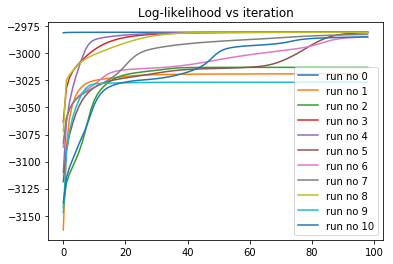

In [13]:
for i,para in enumerate(para_EM):
    plt.plot(range(para[5]), para[4], label = "run no " + str(i))
plt.title("Log-likelihood vs iteration")
plt.legend()
plt.show()

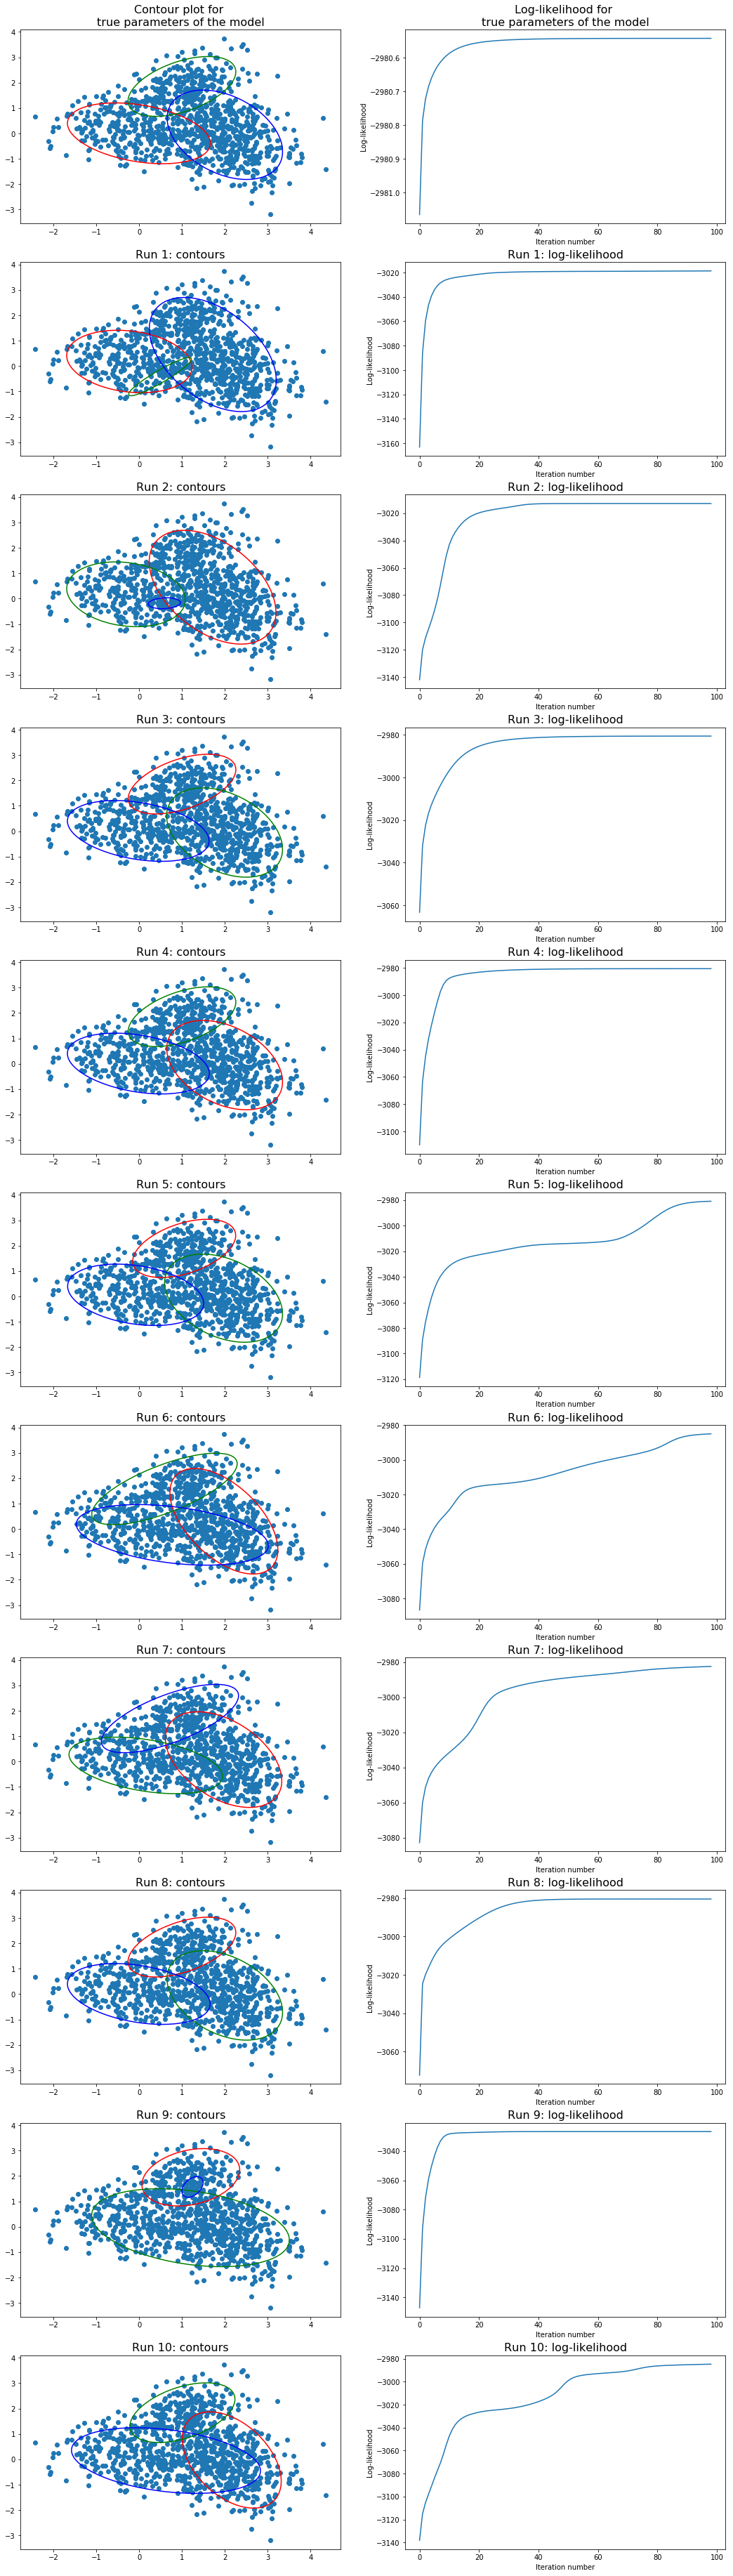

In [46]:
grid_contours = (n_exp, 2);
fig_exp = plt.figure(figsize=(9 * grid_contours[1], 6 * grid_contours[0]))
axs = []
for e in range(n_exp):
    # On the left appears the contour plots for this experiment
    axs.append(plt.subplot2grid(grid_contours, (e, 0), fig=fig_exp))
    if e == 0:
        axs[-1].set_title('Contour plot for \ntrue parameters of the model', fontsize=16)
    else:
        axs[-1].set_title('Run ' + str(e) + ': contours', fontsize=16)
    axs[-1].scatter(X[:,0], X[:,1])
    ax = axs[-1]
    gx = np.linspace(*ax.get_xlim(), 100)
    gy = np.linspace(*ax.get_ylim(), 100)
    gx, gy = np.meshgrid(gx, gy)
    colors = ['red', 'green', 'blue']
    g_inputs = np.empty(gx.shape + (2,))
    g_inputs[:, :, 0] = gx
    g_inputs[:, :, 1] = gy
    
    for k in range(K):
        gaussian_k = multivariate_image.pdf(g_inputs, para_EM[e][1][k], para_EM[e][2][k])
        dist = vec_u[k] - para_EM[e][1][k]
        ax.contour(gx, gy, gaussian_k, 0.2 * np.max(gaussian_k), colors=colors[k])
        
    axs.append(plt.subplot2grid(grid_contours, (e, 1), fig=fig_exp))
    axs[-1].plot(range(n_it), para_EM[e][4])
    if e == 0:
        axs[-1].set_title('Log-likelihood for \ntrue parameters of the model', fontsize=16)
    else:
        axs[-1].set_title('Run ' + str(e) + ': log-likelihood', fontsize=16)
    axs[-1].set_xlabel('Iteration number')
    axs[-1].set_ylabel('Log-likelihood')
    
plt.show()

# Conclusion

As expected, the EM algorithm is highly dependent on the initialization. Although, the algorithm is guaranteed to converge towards a local optima, it is needed to run the algorithm with differents initializations to entually reach the global optima due in part to the highly non-convexity of the problem 

In multivariate gaussian, the mean vector represents the most probable locations of points generated by this gaussian, as expected, the more the initial mean vectors are close to the true mean vector, the more the algorithm produces a satisfactory result.

The real challenge would be to have a good initial guess about the true locations of the points. To avoid local optimas, some algorithms have been proposed such as Stochastic EM which adds another stopping criterion : if the points don't change classes then it has converged. 

